In [1]:
#import torch
import os, sys, re, time
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

240704


In [2]:
import cv2
from ChromAn.src.file_io.data_organization import search_fovs_in_folders, Color_Usage
from ChromAn.src.segmentation_tools.cells import Align_Segmentation

In [3]:
import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from copy import copy

In [4]:
# Cellpose 
from cellpose import models

## Folders

In [5]:
# data_folder
data_folder = r'/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8'
# correction
correction_folder = r'/lab/weissman_imaging/puzheng/Corrections/20230824-Merscope01'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    print(segmentation_save_folder)
    os.makedirs(segmentation_save_folder)
watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation
/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/watershed


In [8]:
# transpose with microscope
parameter_folder = r'/lab/weissman_imaging/puzheng/Softwares/Weissman_MERFISH_Scripts/merlin_parameters'
microscope_file = os.path.join(parameter_folder, 'microscope', 'merscope01_microscope.json')
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.107,
 'image_dimensions': [2304, 2304]}

In [16]:
# search folders
folders, fovs = search_fovs_in_folders(data_folder)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'Color_Usage_merfish.csv')
color_usage_df = Color_Usage(color_usage_filename)

- searching in folder: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8
-- 27 folders, 82 fovs detected.
- load color_usage from file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Analysis/Color_Usage_merfish.csv


In [17]:
# from color_usage, find dapi / polyt / fiducial
dapi_info = color_usage_df.get_dapi_info()[0]
polyt_info = color_usage_df.get_polyt_info()[0]
fiducial_channel = color_usage_df.get_fiducial_channel(color_usage_df)
print(dapi_info, polyt_info, fiducial_channel)

{'hyb': 'H25M9_rep', 'channel': '405'} {'channel': '637', 'hyb': 'H25M9_rep'} 477


# Run segmentation

In [18]:
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d
from merlin.analysis.segment import CellPoseSegment

In [19]:
from importlib import reload

In [20]:
import ChromAn
reload(ChromAn.src.file_io.dax_process)

<module 'ChromAn.src.file_io.dax_process' from '/lab/weissman_imaging/puzheng/Softwares/ChromAn/src/file_io/dax_process.py'>

In [21]:
for _fov_id, _fov_name in enumerate(fovs):

    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    #_ref_cls._corr_illumination()
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls.ref_correction_channel = '637'
    #_cls._corr_illumination()
    _cls._calculate_drift(_ref_im, )
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    
    _dapi_im = getattr(_ref_cls, f"im_{dapi_info['channel']}")
    _polyt_im = getattr(_cls, f"im_{polyt_info['channel']}")
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        #batch_size=60, #anisotropy=250/108,
                                        anisotropy=1000/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=100, 
                                        min_size=2000,
                                        do_3D=False,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = CellPoseSegment.combine_2d_segmentation_masks_into_3d(labels3d)

        # save this segmentation mask
        print(f"- save to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )
    
    #break

reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_00.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_00.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_00.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_00_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.134s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_00.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_00_processed.hdf5
-- all use

- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_4.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_05.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_05.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_05.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_05_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.342s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_05.dax
- New save f

- run Cellpose segmentation in 59.747s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_9.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_10.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_10.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_10.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_10_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.514s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/

- run Cellpose segmentation in 58.427s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_14.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_15.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_15.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_15.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_15_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.402s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8

- run Cellpose segmentation in 74.129s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_19.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_20.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_20.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_20.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_20_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.065s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8

- run Cellpose segmentation in 62.709s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_24.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_25.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_25.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_25.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_25_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.286s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8

- run Cellpose segmentation in 65.797s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_29.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_30.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_30.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_30.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_30_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.196s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8

- run Cellpose segmentation in 63.689s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_34.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_35.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_35.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_35.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_35_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.054s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8

- run Cellpose segmentation in 59.070s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_39.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_40.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_40.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_40.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_40_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.373s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8

- run Cellpose segmentation in 77.028s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_44.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_45.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_45.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_45.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_45_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.154s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8

- run Cellpose segmentation in 62.728s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_49.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_50.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_50.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_50.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_50_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.166s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8

- run Cellpose segmentation in 63.236s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_54.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_55.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_55.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_55.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_55_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.285s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8

- run Cellpose segmentation in 45.606s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_59.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_60.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_60.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_60.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_60_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.142s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8

- run Cellpose segmentation in 59.287s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_64.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_65.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_65.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_65.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_65_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.259s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8

- run Cellpose segmentation in 64.830s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_69.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_70.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_70.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_70.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_70_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.321s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8

- run Cellpose segmentation in 74.233s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_74.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_75.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_75.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_75.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_75_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.389s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8

- run Cellpose segmentation in 54.069s.
- save to file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/Segmentation/segmentation_label_79.npy
reference image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_80.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_80.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_80.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8/H25M9_rep/Conv_zscan_80_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 2.116s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20231230-Intbc-sv40-24edits-MF4dna_4T1preEditTop8

<IPython.core.display.Javascript object>


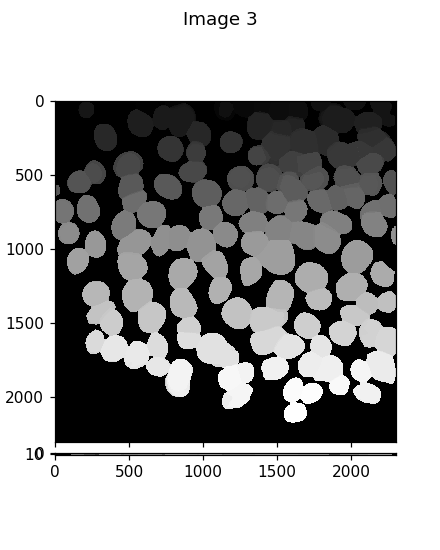

In [14]:
%matplotlib notebook
imshow_mark_3d([_dapi_im, _polyt_im, labels3d])

In [31]:
from merlin.analysis.segment import CellPoseSegment

In [37]:
%%time
combined_labels_3d = CellPoseSegment.combine_2d_segmentation_masks_into_3d(labels3d)

CPU times: user 17.9 s, sys: 3.19 s, total: 21.1 s
Wall time: 21.1 s


<IPython.core.display.Javascript object>


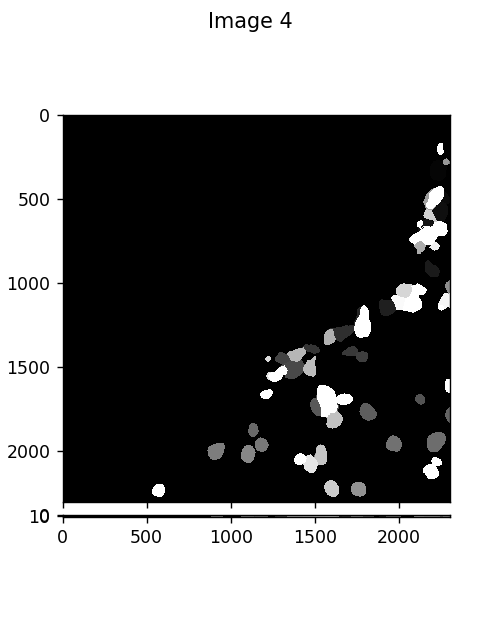

In [38]:
imshow_mark_3d([_dapi_im, _polyt_im, labels3d, combined_labels_3d])

In [ ]:
combined_labels_3d

In [15]:
_ref_cls.correction_log

{'748': {}, '637': {}, '545': {}, '477': {}, '405': {}}

- apply microscope corrections
- run Cellpose segmentation in 179.238s.


In [10]:

for _fov_id, _fov_name in enumerate(fovs):

    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        batch_size=60, #anisotropy=250/108,
                                        anisotropy=1000/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=60, 
                                        min_size=2000,
                                        do_3D=True,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = labels3d.copy() # no modification is required for this one.

        # save this segmentation mask
        print(f"- save to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )

Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_0.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_1.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_2.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_3.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_4.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_l

Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_107.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_108.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_109.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_110.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_111.npy already exists, skip
Segmentation label file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segm

- apply microscope corrections
- run Cellpose segmentation in 142.370s.
- save to file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_20.npy


<IPython.core.display.Javascript object>


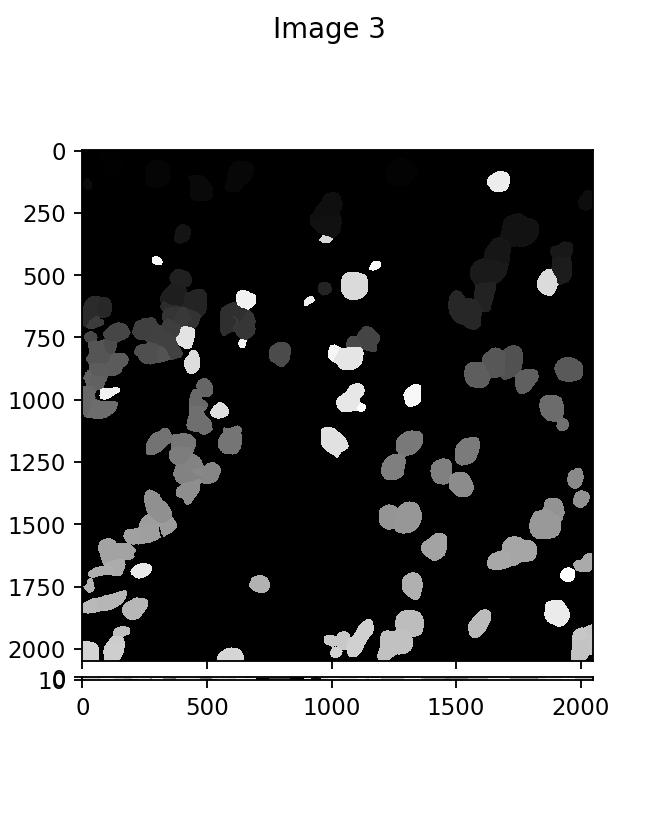

In [24]:
%matplotlib notebook
imshow_mark_3d([polyt_im, dapi_im, corr_labels3d])

# STEP2: Watershed: Optional, potentially make it worse

In [11]:
watershed_th = 1.6

for _fov_id, _fov_name in enumerate(fovs):
    

    _save_id = _fov_id 
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    
    
    _save_id = _fov_id 

    dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, watershed_th)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    #np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    break

- directly load seg from: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_0.npy
reference image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
PolyT and DAPI image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H19R1\Conv_zscan_000.dax
Initialize DaxProcesser for file:\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
- New save file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488', '405'] in 1.732s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:[

<IPython.core.display.Javascript object>


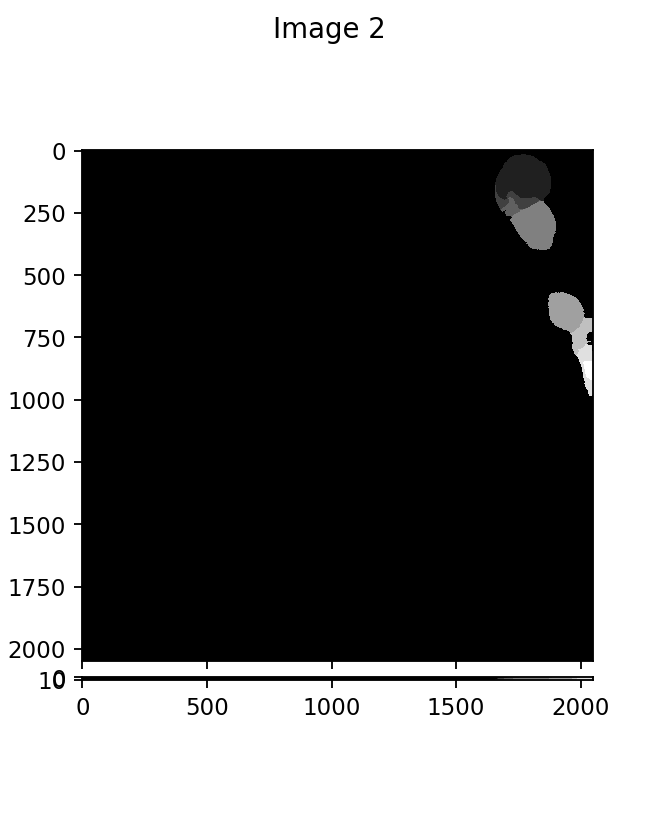

In [203]:
imshow_mark_3d([new_labels, corr_labels3d])

## visualize merlin_output_tif

In [12]:
import tifffile
ims = tifffile.imread(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4\FiducialCorrelationWarp\images\aligned_fiducial_images30.tif')